In [1]:
import os 
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-GPU-bb1ccb6e-2bc9-c7a1-b25d-3eef9033e192/3/0"

n_epochs = 25

In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 

In [3]:
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics, ToUnknown, ToRGB
from pytorch_ood.dataset.img import Textures, LSUNCrop, LSUNResize, TinyImageNetCrop, TinyImageNetResize
from torchvision.datasets import CIFAR100
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

def test(model):
    
    prep = Compose([
        ToRGB(),
        Resize([32,32]),
        ToTensor(),
        Normalize(
            std=[0.24705882352941176470, 0.24352941176470588235, 0.26156862745098039215], 
            mean=[0.49137254901960784313, 0.48235294117647058823, 0.44666666666666666666]), 
        ])

    metrics = [] 
    
    with torch.no_grad():
        model.eval()

        data_in = CIFAR100(root="/data_fast/kirchheim/datasets/", download=True, transform=prep, train=False)

        for Data_clz in [Textures, LSUNCrop, LSUNResize, TinyImageNetCrop, TinyImageNetResize]:
            ood_name = Data_clz.__name__

            data_out = Data_clz(root="/data_fast/kirchheim/datasets/", transform=prep, download=True, 
                                target_transform=ToUnknown())

            data_loader = DataLoader(data_in + data_out, batch_size=128, num_workers=10)

            # create detector
            softmax = MaxSoftmax(model)
            energy = EnergyBased(model)

            # evaluate
            metric_softmax = OODMetrics()
            metric_energy = OODMetrics()

            for x, y in data_loader:
                logits = model(x.cuda())
                metric_softmax.update(softmax.score(logits), y)
                metric_energy.update(energy.score(logits), y)

            # print(ood_name, metric_softmax.compute())

            m = metric_softmax.compute()
            m.update({
                "Dataset": ood_name,
                "Method": "Softmax"
            })
            metrics.append(m)
            
            m = metric_energy.compute()
            m.update({
                "Dataset": ood_name,
                "Method": "Energy"
            })
            metrics.append(m)
    
    model.train()
    
    return metrics

In [4]:
# create Neural Network
model = WideResNet(pretrained="cifar100-pt", num_classes=100).eval().cuda()
metrics = test(model)

Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [5]:
import pandas as pd 

data = pd.DataFrame(metrics)
print((data.groupby(["Method"]).mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR \\
Method  &        &          &           &           &           \\
\midrule
Energy  &  84.41 &    79.72 &     86.85 &     71.38 &     48.55 \\
Softmax &  78.71 &    73.35 &     82.58 &     66.36 &     58.58 \\
\bottomrule
\end{tabular}



In [44]:
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures
from torchvision.datasets import CIFAR100 
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

from pytorch_ood.loss import OutlierExposureLoss
from torch.optim import SGD
from tqdm import tqdm

torch.manual_seed(10)

prep = Compose([
    ToPILImage(),
    Resize([32,32]),
    ToTensor(),
    Normalize(
        std=[0.24705882352941176470, 0.24352941176470588235, 0.26156862745098039215], 
        mean=[0.49137254901960784313, 0.48235294117647058823, 0.44666666666666666666]), 
    ])

mt = Compose([
    #ToPILImage(),
    Resize([32,32]),
    ToTensor(),
    Normalize(
        std=[0.24705882352941176470, 0.24352941176470588235, 0.26156862745098039215], 
        mean=[0.49137254901960784313, 0.48235294117647058823, 0.44666666666666666666]), 
    ])

x = torch.load("samples-c100.pt")
gan_oe_data = torch.stack([prep(t) for t in x])
gan_oe_label = torch.ones(size=(len(x),)).long() * -1

data_in_train = CIFAR100(root="data/", download=True, transform=mt, target_transform=torch.tensor)
data_out_train = TensorDataset(gan_oe_data,gan_oe_label)
train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)
      
# create Neural Network
model = WideResNet(pretrained="cifar100-pt", num_classes=100).cuda()
opti = SGD(model.parameters(), lr=0.001)

criterion = OutlierExposureLoss(alpha=0.5)

mav = 0.0
mavs = []

metrics_goe = []


# initial test round 
r = test(model)
for entry in r:
    entry.update({"Epoch": -1})
metrics_goe += r

for i in range(n_epochs):
    print(f"Epoch {i}")
    
    # train 
    model.train()
    bar = tqdm(train_loader)
    for x, y in bar:
        opti.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, y.cuda())
        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        loss.backward()
        opti.step()
        bar.set_postfix({"loss": mav})
        
    print(80*"#")
    
    r = test(model)
    for entry in r:
        entry.update({"Epoch": i})
    
    metrics_goe += r

Files already downloaded and verified
Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Epoch 0


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.22it/s, loss=1.97]


################################################################################
Files already downloaded and verified
Epoch 1


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.23it/s, loss=1.76]


################################################################################
Files already downloaded and verified
Epoch 2


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.22it/s, loss=1.58]


################################################################################
Files already downloaded and verified
Epoch 3


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.21it/s, loss=1.58]


################################################################################
Files already downloaded and verified
Epoch 4


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.23it/s, loss=1.52]


################################################################################
Files already downloaded and verified
Epoch 5


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.23it/s, loss=1.52]


################################################################################
Files already downloaded and verified
Epoch 6


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.23it/s, loss=1.48]


################################################################################
Files already downloaded and verified
Epoch 7


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.23it/s, loss=1.43]


################################################################################
Files already downloaded and verified
Epoch 8


100%|████████████████████████████████████████████| 391/391 [02:01<00:00,  3.23it/s, loss=1.39]


################################################################################
Files already downloaded and verified
Epoch 9


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.45]


################################################################################
Files already downloaded and verified
Epoch 10


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.38]


################################################################################
Files already downloaded and verified
Epoch 11


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.38]


################################################################################
Files already downloaded and verified
Epoch 12


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.37]


################################################################################
Files already downloaded and verified
Epoch 13


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.42]


################################################################################
Files already downloaded and verified
Epoch 14


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.34]


################################################################################
Files already downloaded and verified
Epoch 15


100%|█████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.4]


################################################################################
Files already downloaded and verified
Epoch 16


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.38]


################################################################################
Files already downloaded and verified
Epoch 17


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.41]


################################################################################
Files already downloaded and verified
Epoch 18


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.38]


################################################################################
Files already downloaded and verified
Epoch 19


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.36]


################################################################################
Files already downloaded and verified
Epoch 20


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.34]


################################################################################
Files already downloaded and verified
Epoch 21


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.33]


################################################################################
Files already downloaded and verified
Epoch 22


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.35]


################################################################################
Files already downloaded and verified
Epoch 23


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.25it/s, loss=1.35]


################################################################################
Files already downloaded and verified
Epoch 24


100%|████████████████████████████████████████████| 391/391 [02:00<00:00,  3.24it/s, loss=1.34]


################################################################################
Files already downloaded and verified


In [45]:
data = pd.DataFrame(metrics_goe)
tmp = data[data["Epoch"] == n_epochs -1]
print((tmp.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method  &        &          &           &           \\
\midrule
Energy  &  92.68 &    89.72 &     94.48 &     26.26 \\
Softmax &  91.61 &    89.05 &     93.33 &     33.43 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Epoch', ylabel='AUROC'>

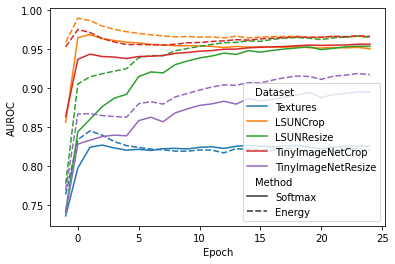

In [8]:
sb.lineplot(data=data, y="AUROC", x="Epoch", style="Method", hue="Dataset")

In [9]:
"""
Do it with uniformely distributed outlier samples 
"""
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures
from torchvision.datasets import CIFAR100 
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

from pytorch_ood.loss import OutlierExposureLoss
from torch.optim import SGD
from tqdm import tqdm

torch.manual_seed(10)


# TODO: use 80,000?
x = torch.randint(0, 255, size=(80000, 3, 32, 32), dtype=torch.uint8) #  torch.load("samples.pt")[:80000]
gan_oe_data = torch.stack([prep(t) for t in x])
gan_oe_label = torch.ones(size=(len(x),)).long() * -1

data_in_train = CIFAR100(root="data", download=True, transform=mt, target_transform=torch.tensor)
data_out_train = TensorDataset(gan_oe_data,gan_oe_label)
train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)
      
# create Neural Network
model = WideResNet(pretrained="cifar100-pt", num_classes=100).cuda()
opti = SGD(model.parameters(), lr=0.001)

criterion = OutlierExposureLoss(alpha=0.5)

mav = 0.0
mavs = []

metrics_noise = []


# initial test round 
r = test(model)
for entry in r:
    entry.update({"Epoch": -1})
metrics_noise += r


for i in range(n_epochs):
    print(f"Epoch {i}")
    
    # train 
    model.train()
    bar = tqdm(train_loader)
    for x, y in bar:
        opti.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, y.cuda())
        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        loss.backward()
        opti.step()
        bar.set_postfix({"loss": mav})
        
    print(80*"#")
    
    r = test(model)
    for entry in r:
        entry.update({"Epoch": i})
    
    metrics_noise += r

Files already downloaded and verified
Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Epoch 0


100%|████████████████████████████████████████████████████| 508/508 [02:37<00:00,  3.23it/s, loss=1.78]


################################################################################
Files already downloaded and verified
Epoch 1


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.64]


################################################################################
Files already downloaded and verified
Epoch 2


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.54]


################################################################################
Files already downloaded and verified
Epoch 3


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.57]


################################################################################
Files already downloaded and verified
Epoch 4


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.55]


################################################################################
Files already downloaded and verified
Epoch 5


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.57]


################################################################################
Files already downloaded and verified
Epoch 6


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.53]


################################################################################
Files already downloaded and verified
Epoch 7


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.54]


################################################################################
Files already downloaded and verified
Epoch 8


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.44]


################################################################################
Files already downloaded and verified
Epoch 9


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.51]


################################################################################
Files already downloaded and verified
Epoch 10


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.49]


################################################################################
Files already downloaded and verified
Epoch 11


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.45]


################################################################################
Files already downloaded and verified
Epoch 12


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.48]


################################################################################
Files already downloaded and verified
Epoch 13


100%|█████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.5]


################################################################################
Files already downloaded and verified
Epoch 14


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.47]


################################################################################
Files already downloaded and verified
Epoch 15


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.48]


################################################################################
Files already downloaded and verified
Epoch 16


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.52]


################################################################################
Files already downloaded and verified
Epoch 17


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.49]


################################################################################
Files already downloaded and verified
Epoch 18


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.48]


################################################################################
Files already downloaded and verified
Epoch 19


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.51]


################################################################################
Files already downloaded and verified
Epoch 20


100%|████████████████████████████████████████████████████| 508/508 [02:37<00:00,  3.23it/s, loss=1.45]


################################################################################
Files already downloaded and verified
Epoch 21


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.45]


################################################################################
Files already downloaded and verified
Epoch 22


100%|████████████████████████████████████████████████████| 508/508 [02:37<00:00,  3.23it/s, loss=1.46]


################################################################################
Files already downloaded and verified
Epoch 23


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.45]


################################################################################
Files already downloaded and verified
Epoch 24


100%|████████████████████████████████████████████████████| 508/508 [02:36<00:00,  3.24it/s, loss=1.53]


################################################################################
Files already downloaded and verified


In [41]:
data = pd.DataFrame(metrics_noise)
tmp = data[data["Epoch"] == n_epochs - 1]
print((tmp.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method  &        &          &           &           \\
\midrule
Energy  &  91.57 &    89.20 &     93.17 &     33.05 \\
Softmax &  80.75 &    76.22 &     84.69 &     53.76 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Epoch', ylabel='AUROC'>

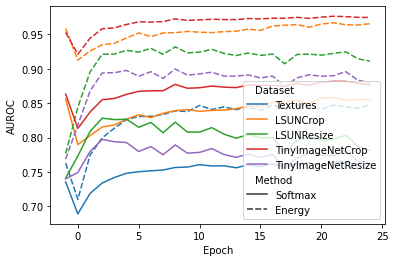

In [11]:
sb.lineplot(data=data, y="AUROC", x="Epoch", style="Method", hue="Dataset")

In [53]:
"""
Do it with the usual (non-synthetic outliers)
"""
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures, TinyImages300k
from torchvision.datasets import CIFAR100 
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

from pytorch_ood.loss import OutlierExposureLoss
from torch.optim import SGD
from tqdm import tqdm

torch.manual_seed(10)


data_out_train = TinyImages300k(root="/data_fast/kirchheim/datasets/", transform=mt, download=True, 
                                target_transform=ToUnknown())

data_in_train = CIFAR100(root="data/", download=True, transform=mt)
train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)
      
# create Neural Network
model = WideResNet(pretrained="cifar100-pt", num_classes=100).cuda()
opti = SGD(model.parameters(), lr=0.001)

criterion = OutlierExposureLoss(alpha=0.5)

mav = 0.0
mavs = []

metrics_oe = []


# initial test round 
r = test(model)
for entry in r:
    entry.update({"Epoch": -1})
metrics_oe += r


for i in range(n_epochs):
    print(f"Epoch {i}")
    
    # train 
    model.train()
    bar = tqdm(train_loader)
    for x, y in bar:
        opti.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, y.cuda())
        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        loss.backward()
        opti.step()
        bar.set_postfix({"loss": mav})
        
    print(80*"#")
    
    r = test(model)
    for entry in r:
        entry.update({"Epoch": i})
    
    metrics_oe += r

Files already downloaded and verified
Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Epoch 0


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.85]


################################################################################
Files already downloaded and verified
Epoch 1


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.52]


################################################################################
Files already downloaded and verified
Epoch 2


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.39]


################################################################################
Files already downloaded and verified
Epoch 3


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.35]


################################################################################
Files already downloaded and verified
Epoch 4


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.33]


################################################################################
Files already downloaded and verified
Epoch 5


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.28]


################################################################################
Files already downloaded and verified
Epoch 6


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.29]


################################################################################
Files already downloaded and verified
Epoch 7


100%|██████████████████████████████████████████| 1368/1368 [06:56<00:00,  3.29it/s, loss=2.31]


################################################################################
Files already downloaded and verified
Epoch 8


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.26]


################################################################################
Files already downloaded and verified
Epoch 9


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.30it/s, loss=2.27]


################################################################################
Files already downloaded and verified
Epoch 10


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.30it/s, loss=2.27]


################################################################################
Files already downloaded and verified
Epoch 11


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.27]


################################################################################
Files already downloaded and verified
Epoch 12


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.30it/s, loss=2.28]


################################################################################
Files already downloaded and verified
Epoch 13


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.31]


################################################################################
Files already downloaded and verified
Epoch 14


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.27]


################################################################################
Files already downloaded and verified
Epoch 15


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.26]


################################################################################
Files already downloaded and verified
Epoch 16


100%|██████████████████████████████████████████| 1368/1368 [06:56<00:00,  3.29it/s, loss=2.25]


################################################################################
Files already downloaded and verified
Epoch 17


100%|██████████████████████████████████████████| 1368/1368 [06:56<00:00,  3.29it/s, loss=2.25]


################################################################################
Files already downloaded and verified
Epoch 18


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.30it/s, loss=2.25]


################################################################################
Files already downloaded and verified
Epoch 19


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.23]


################################################################################
Files already downloaded and verified
Epoch 20


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.24]


################################################################################
Files already downloaded and verified
Epoch 21


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.25]


################################################################################
Files already downloaded and verified
Epoch 22


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.30it/s, loss=2.23]


################################################################################
Files already downloaded and verified
Epoch 23


100%|██████████████████████████████████████████| 1368/1368 [06:54<00:00,  3.30it/s, loss=2.22]


################################################################################
Files already downloaded and verified
Epoch 24


100%|██████████████████████████████████████████| 1368/1368 [06:55<00:00,  3.29it/s, loss=2.25]


################################################################################
Files already downloaded and verified


In [54]:
data = pd.DataFrame(metrics_oe)
tmp = data[data["Epoch"] == n_epochs -1]
print((tmp.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method  &        &          &           &           \\
\midrule
Energy  &  86.29 &    78.60 &     89.69 &     37.18 \\
Softmax &  87.13 &    81.49 &     89.97 &     37.91 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Epoch', ylabel='AUROC'>

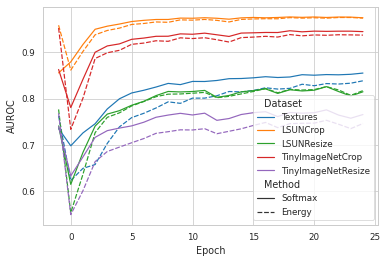

In [43]:
sb.lineplot(data=data, x="Epoch", y="AUROC", style="Method", hue="Dataset")

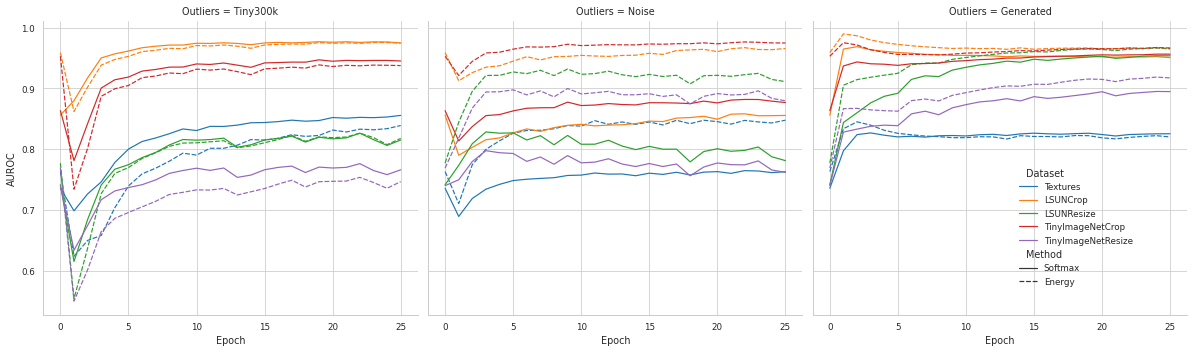

In [34]:
from matplotlib import rcParams
rcParams['pgf.texsystem'] = "pdflatex"

sb.set_style("whitegrid")
sb.set_context("paper")

data_oe = pd.DataFrame(metrics_oe)
data_noise = pd.DataFrame(metrics_noise)
data_goe = pd.DataFrame(metrics_goe)

data_oe["Outliers"] = "Tiny300k"
data_noise["Outliers"] = "Noise"
data_goe["Outliers"] = "Generated"

tmp = pd.concat([data_oe, data_noise, data_goe])
tmp["Epoch"] += 1 
g = sb.relplot(data=tmp, col="Outliers",  x="Epoch", y="AUROC", style="Method", hue="Dataset", kind="line")
# plt.legend()
leg = g.legend
leg.set_bbox_to_anchor([0.95,0.35]) 

plt.tight_layout()
plt.savefig(f"img/c100-auroc-over-time.png", dpi=300)
plt.savefig(f"img/c100-auroc-over-time.pgf", dpi=300)

In [46]:
data = np.load(f"samples-c100-large.npz")
x = torch.tensor(data["x"])
x.shape

torch.Size([500000, 3, 32, 32])

In [ ]:
torch.manual_seed(10)

# TODO: use 80,000?
# data = np.load(f"samples-c100-large.npz")

metrics_l = []
    
for l in [100, 1000, 10000, 20000, 50000, 100000]:
    print(l)
    xn = x[:l]
    gan_oe_data = torch.stack([prep(t) for t in xn])
    gan_oe_label = torch.ones(size=(len(xn),)).long() * -1

    data_in_train = CIFAR100(root="data/", download=True, transform=mt, target_transform=torch.tensor)
    data_out_train = TensorDataset(gan_oe_data, gan_oe_label)
    train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)

    # create Neural Network
    model = WideResNet(pretrained="cifar100-pt", num_classes=100).cuda()
    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []

    r = test(model)
    for entry in r:
        entry.update({
            "Epoch": -1,
            "Length": l
        })

    metrics_l += r
        

    for i in range(n_epochs):
        print(f"Epoch {i}")

        # train 
        model.train()
        bar = tqdm(train_loader)
        for x, y in bar:
            opti.zero_grad()
            y_hat = model(x.cuda())
            loss = criterion(y_hat, y.cuda())
            mav = 0.2 * loss.item() + 0.8 * mav
            mavs.append(mav)

            loss.backward()
            opti.step()
            bar.set_postfix({"loss": mav})

        print(80*"#")

        r = test(model)
        for entry in r:
            entry.update({
                "Epoch": i,
                "Length": l
            })

        metrics_l += r

100
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.199]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.12it/s, loss=0.158]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.12it/s, loss=0.137]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.139]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.13it/s, loss=0.131]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.134]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.132]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.143]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.122]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.16it/s, loss=0.127]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.16it/s, loss=0.123]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.16it/s, loss=0.122]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.135]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.16it/s, loss=0.119]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.15it/s, loss=0.131]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.16it/s, loss=0.127]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.11it/s, loss=0.125]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.12it/s, loss=0.119]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.12it/s, loss=0.116]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.13it/s, loss=0.111]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.12it/s, loss=0.112]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.13it/s, loss=0.117]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.13it/s, loss=0.137]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.14it/s, loss=0.121]


################################################################################
Files already downloaded and verified
Epoch 24


100%|███████████████████████████████████████████████████| 196/196 [01:02<00:00,  3.13it/s, loss=0.109]


################################################################################
Files already downloaded and verified
1000
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 197/197 [01:01<00:00,  3.19it/s, loss=0.54]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.16it/s, loss=0.693]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.502]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.621]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.512]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.242]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.18it/s, loss=0.395]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.414]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.392]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.368]


################################################################################
Files already downloaded and verified
Epoch 10


100%|████████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.18it/s, loss=0.51]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.186]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.328]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.498]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.535]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.344]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.394]


################################################################################
Files already downloaded and verified
Epoch 17


100%|████████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.43]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.364]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.13it/s, loss=0.503]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.349]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.16it/s, loss=0.472]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.438]


################################################################################
Files already downloaded and verified
Epoch 23


100%|████████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.42]


################################################################################
Files already downloaded and verified
Epoch 24


100%|████████████████████████████████████████████████████| 197/197 [01:02<00:00,  3.17it/s, loss=0.61]


################################################################################
Files already downloaded and verified
10000
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|███████████████████████████████████████████████████| 196/196 [01:01<00:00,  3.17it/s, loss=0.208]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████████████████████████████| 196/196 [01:01<00:00,  3.17it/s, loss=0.172]


################################################################################
Files already downloaded and verified
Epoch 2


100%|████████████████████████████████████████████████████| 196/196 [01:01<00:00,  3.18it/s, loss=0.15]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████████████████████████████| 196/196 [01:01<00:00,  3.18it/s, loss=0.121]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████████████████████████████| 196/196 [01:01<00:00,  3.17it/s, loss=0.128]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████████████████████████████| 196/196 [01:01<00:00,  3.18it/s, loss=0.136]


################################################################################


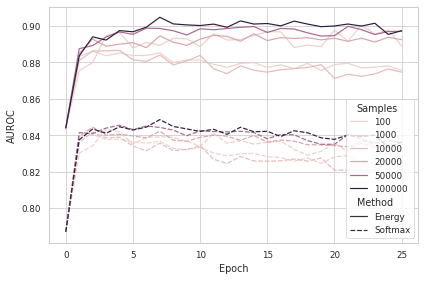

In [50]:
tmp = pd.DataFrame(metrics_l)
tmp["Samples"] = tmp["Length"]
tmp["Epoch"] = tmp["Epoch"] + 1 
tmp = tmp.groupby(["Epoch", "Samples", "Method"]).mean()

sb.lineplot(data=tmp,  x="Epoch", y="AUROC", hue="Samples", style="Method") 
plt.tight_layout()
plt.savefig("img/size-vs-auroc-c100.png", dpi=300)
plt.savefig("img/size-vs-auroc-c100.pgf", dpi=300)